<a href="https://colab.research.google.com/github/Daniel-Wait/SKRIPSIE_workbooks/blob/master/SKRIPSIE_overlap_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
DB WAIT
20887507

"""
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
from matplotlib import pylab as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Import different modules for using with the notebook
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

#A helper-function to setup a proper plot
def setup_plot(title, y_label='', x_label='', newfig=True):
  if newfig:
    plt.figure()
  plt.margins(*(plt.array(plt.margins())+0.05))
  plt.title(title)
  plt.ylabel(y_label)
  plt.xlabel(x_label)

#A helper-function to setup a proper plot
def fsk(bitseq, spb, f_0, f_1, F):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb))
  mn = np.zeros(shape = (spb*nb,))
  mn_len = np.array(range(0, mn.shape[0]))
  
  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T)
    mn[i*spb:(i+1)*spb] = bit

  setup_plot("Modulated Signal")
  plt.plot(mn, 'c')
  #plt.stem(mn, use_line_collection=True, markerfmt= 'r.', linefmt = 'r:')
  plt.show()
  
  return mn

def pollute(bitseq, len_f, len_b, spb, f_0, f_1, F, gain, timeshift, noise_stddev):
  T = 1/F  
  nb = bitseq.shape[0]
  num = np.array(range(0, spb)) 
  rn = np.zeros(shape = (spb*nb,))
  phase1 = 2*np.pi*f_1*timeshift
  phase0 = 2*np.pi*f_0*timeshift

  for i in range(0, nb):
    if (bitseq[i] == 1): 
      bit = np.sin(2*f_1*np.pi*num*T + phase1)
    if (bitseq[i] == 0):
      bit = np.sin(2*f_0*np.pi*num*T + phase0)
    rn[i*spb:(i+1)*spb] = bit
  
  rn = np.insert(rn, 0, np.zeros(shape = (len_f,)) )
  rn = np.append(rn, np.zeros(shape = (len_b,)) )
  wn = np.random.normal(loc=0.0, scale=noise_stddev, size=(nb*spb + len_f + len_b,))
  rn = gain*rn + wn

  setup_plot("Received Signal")
  plt.plot(rn, 'm')
  #plt.stem(rn, use_line_collection=True, markerfmt= 'g.', linefmt = 'g:')
  plt.show()
  
  return rn

**Set sampling rate and determine valid modulating frequencies**

In [2]:
fs = 44100
Ts = 1/fs

Tb = 20e-3
samps = int(Tb*fs) 
print(samps)

n = 10
delta_f = n/(2*Tb)
print(delta_f)

f1 = delta_f*10
f0 = delta_f*20
print(f0, f1)

bits = np.array([1,0,0,1,1,0,1,1])

882
250.0
5000.0 2500.0


**Check Frequency Content and Autocorrelation of an FSK Modulated message**

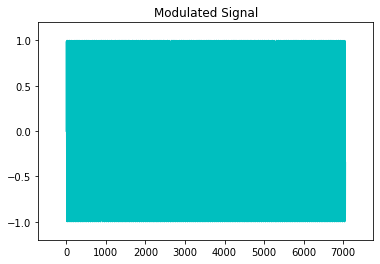

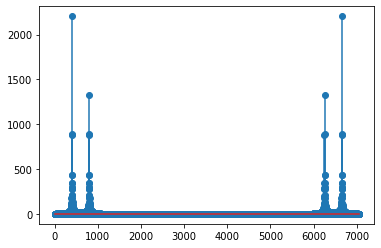

Bin: 400
Frq: 2500.0
Mag: 2204.9999999999986
Bin: 800
Frq: 5000.0
Mag: 1322.999999999999


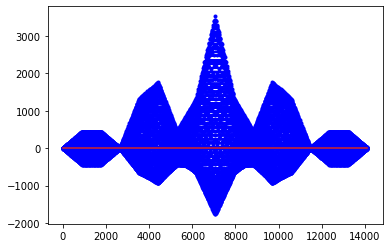

In [3]:
tx = fsk(bitseq = bits, spb = samps, f_0 = f0, f_1 = f1, F = fs)

tf = np.abs(np.fft.fft(tx))
plt.stem(tf, use_line_collection= True)
plt.show()

for k in range(0, samps*4):
  if tf[k] > 1000:
    print("Bin:", k)
    print("Frq:", fs*k/(tx.shape[0]))
    print("Mag:", tf[k])

rtt = np.correlate(tx, tx, mode = 'full')
plt.stem(rtt, linefmt="b:", markerfmt = 'b.', use_line_collection= True)
plt.show() 

**Check Frequency Content and Cross-correlation of a received FSK message**

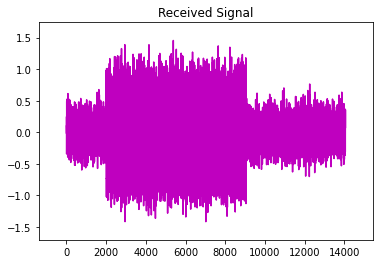

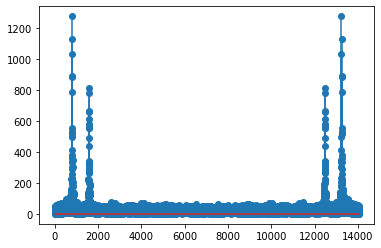

Bin: 797
Frq: 2500.5478087649403
Mag: 887.8342110994712
Bin: 802
Frq: 2516.235059760956
Mag: 888.817346736638
Bin: 808
Frq: 2535.0597609561755
Mag: 1129.3146616447007
Bin: 812
Frq: 2547.609561752988
Mag: 1034.5885714637334
Bin: 813
Frq: 2550.7470119521913
Mag: 1278.0156525288749
Bin: 1578
Frq: 4950.896414342629
Mag: 814.6260171897287


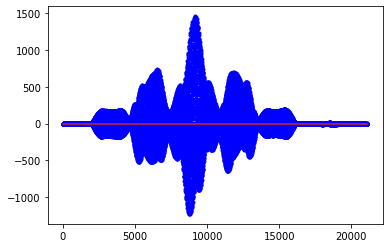

In [4]:
rx = pollute(bitseq = bits, len_f = 2000, len_b= 5000,spb = samps, f_0 = f0-30, f_1 = f1+30, F = fs, gain = 0.8, timeshift= 0.5*Ts, noise_stddev=0.2)

rf = np.abs(np.fft.fft(rx))
plt.stem(rf, use_line_collection= True)
plt.show()

for k in range(0, samps*4):
  if rf[k] > 800:
    print("Bin:", k)
    print("Frq:", fs*k/(rx.shape[0]))
    print("Mag:", rf[k])

rtr = np.correlate(rx, tx, mode = "full")
plt.stem(rtr, linefmt="b:", markerfmt = 'b.', use_line_collection= True)
plt.show() 

**Define Matched Filter coefficients**

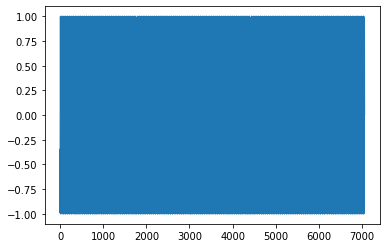

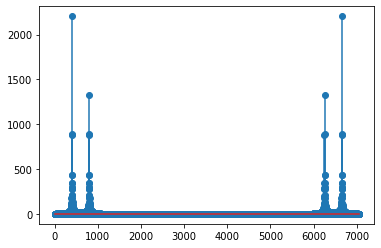

In [5]:
mf_coef= np.flip(tx)

plt.plot(mf_coef)
plt.show()

mf_fft = np.abs(np.fft.fft(mf_coef))
plt.stem(mf_fft, use_line_collection= True)
plt.show()

**Sanity Check: does convolution of filter with received signal reproduce cross-correlation function?**

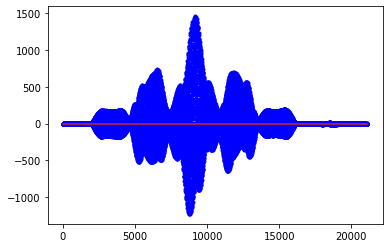

In [6]:
conv = np.convolve(mf_coef, rx, mode = "full")
plt.stem(conv, linefmt="b:", markerfmt = 'b.', use_line_collection= True)
plt.show()

**OVERLAP-ADD Implementation of the above filter**

7056
6656
16384
16384


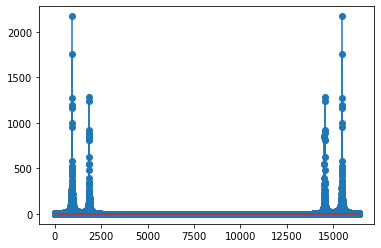

14056
*******
0
6656
16384


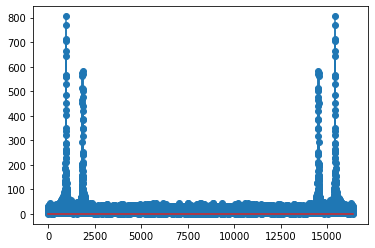

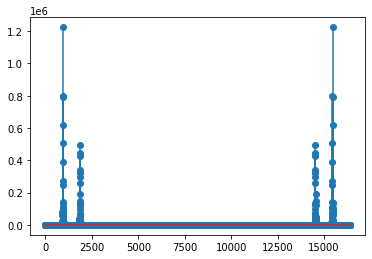

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


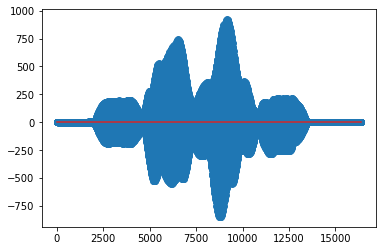

*******
6656
6656
16384


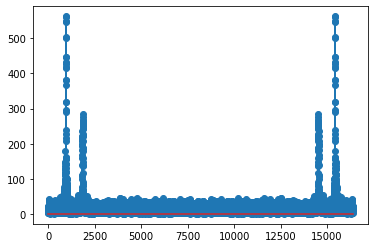

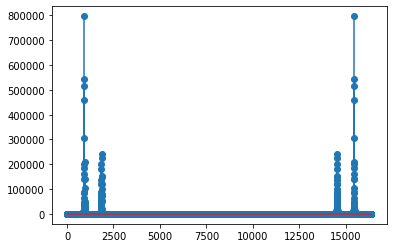

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


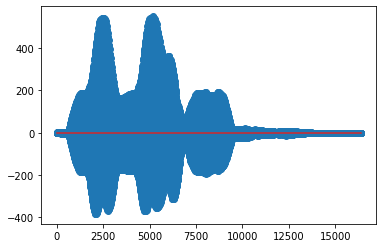

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


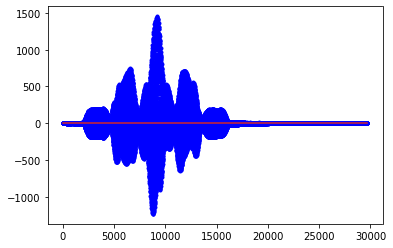

In [ ]:
M = mf_coef.shape[0]
L = 128*52
N = 2**(math.ceil(math.log2(M+L-1)))
print(M)
print(L)
print(N)

mf_coef_n = np.append(mf_coef, np.zeros(shape = (N-M,)) )
print(mf_coef_n.shape[0])

mf_fft_n = np.fft.fft(mf_coef_n)
plt.stem(np.abs(mf_fft_n), use_line_collection=True)
plt.show()

print(rx.shape[0])
xin = np.zeros(shape = (2,N), dtype= np.complex64)

for i in range(0, 2):
  print("*******")
  index = i*L
  print(index)
  xn = rx[index:index+L]
  print(xn.shape[0])
  xn = np.append(xn, np.zeros(shape = (N-L,)) )
  print(xn.shape[0])
  xf = np.fft.fft(xn)
  plt.stem(np.abs(xf), use_line_collection=True)
  plt.show()
  xf = xf*mf_fft_n
  plt.stem(np.abs(xf), use_line_collection=True)
  plt.show()
  xin[i] = np.fft.ifft(xf)
  plt.stem(xin[i], use_line_collection=True)
  plt.show()

yn = np.zeros(shape=(3*N,), dtype=np.complex64)


yn[0:L] = xin[0][0:L]
yn[L:N] = xin[0][L:N] + xin[1][0:N-L]
yn[N:N+L] = xin[1][N-L:N]

plt.stem(yn[0:N+2*L], linefmt="b:", markerfmt = 'b.', use_line_collection= True)
plt.show()


  


**Define a 12-bit message and perform similar checks as above**

882
250.0
5000.0 2500.0


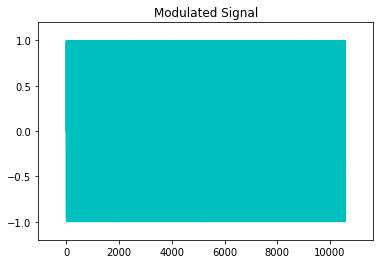

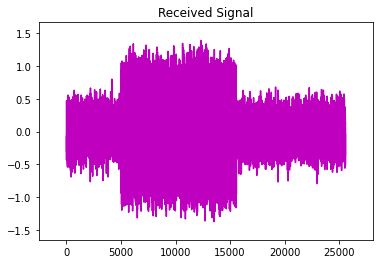

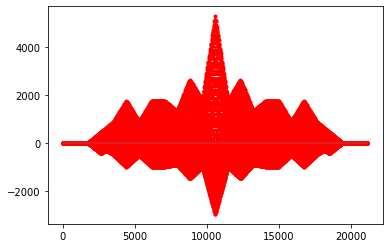

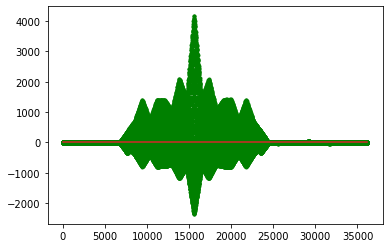

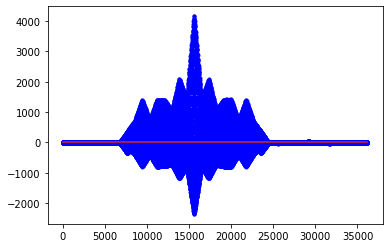

In [7]:
fs = 44100
Ts = 1/fs

Tb = 20e-3
samps = int(Tb*fs) 
print(samps)

n = 10
delta_f = n/(2*Tb)
print(delta_f)

f1 = delta_f*10
f0 = delta_f*20
print(f0, f1)

bits1 = np.array([0,0,1,0,1,0,1,0,0,1,1,1])

tx1 = fsk(bitseq = bits1, spb = samps, f_0 = f0, f_1 = f1, F = fs)
rx1 = pollute(bitseq = bits1, len_f = 5000, len_b = 10000, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 0.8, timeshift= 0.5*Ts, noise_stddev=0.2)

rtt = np.correlate(tx1, tx1, mode = "full")
plt.stem(rtt, linefmt="r:", markerfmt = 'r.', use_line_collection= True)
plt.show()

rtr = np.correlate(rx1, tx1, mode = "full")
plt.stem(rtr, linefmt="g:", markerfmt = 'g.', use_line_collection= True)
plt.show() 

mf_coef= np.flip(tx1)
mf_fft = np.abs(np.fft.fft(mf_coef))

conv = np.convolve(rx1, mf_coef, mode = "full")
plt.stem(conv, linefmt="b:", markerfmt = 'b.', use_line_collection= True)
plt.show()

**OVERLAP-ADD of 12-bit signal**

10584
6656
32768


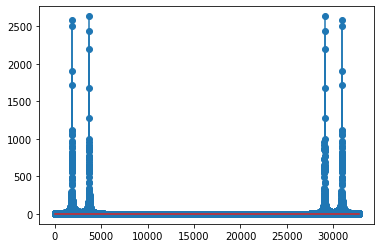

25584
*******
0


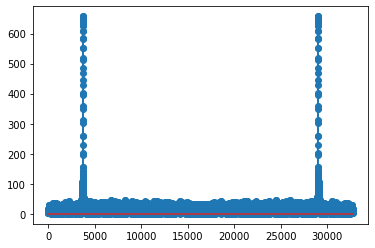

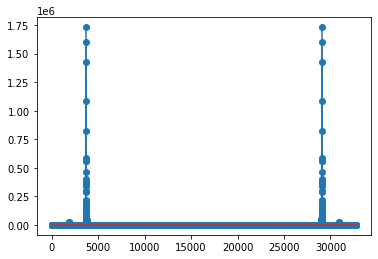

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


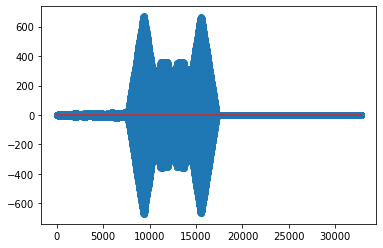

*******
6656


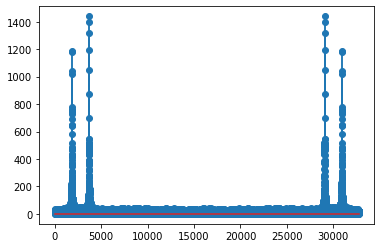

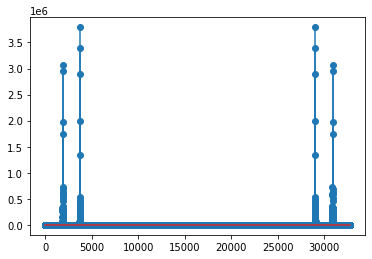

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


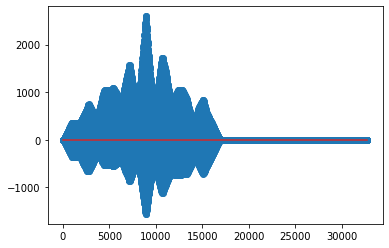

*******
13312


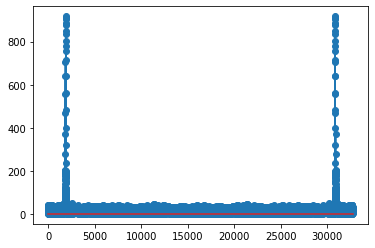

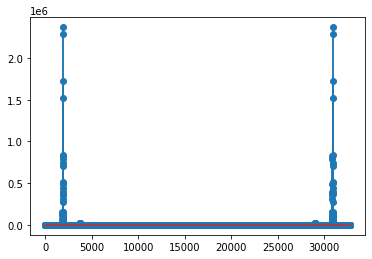

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


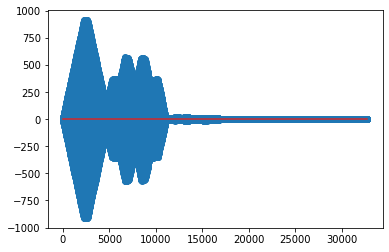

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


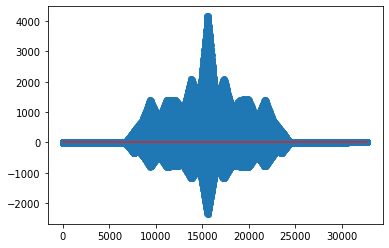

In [8]:
M = mf_coef.shape[0]
L = 128*52
N = 2**(math.ceil(math.log2(M+L-1)))
print(M)
print(L)
print(N)

mf_coef_n = np.append(mf_coef, np.zeros(shape = (N-M,)) )

mf_fft_n = np.fft.fft(mf_coef_n)
plt.stem(np.abs(mf_fft_n), use_line_collection=True)
plt.show()

"""
for j in range(0, mf_fft_n.shape[0]):
  if(mf_fft_n[j] < 0.01):
    mf_fft_n[j] = 0.0 
"""

print(rx1.shape[0])
xin = np.zeros(shape = (3,N), dtype= np.complex64)

for i in range(0, 3):
  print("*******")
  index = i*L
  print(index)

  xn = rx1[index:index+L]
  #print(xn.shape[0])
  xn = np.append(xn, np.zeros(shape = (N-L,)) )
  #print(xn.shape[0])

  xf = np.fft.fft(xn)
  plt.stem(np.abs(xf), use_line_collection=True)
  plt.show()

  xf = xf*mf_fft_n
  plt.stem(np.abs(xf), use_line_collection=True)
  plt.show()

  xin[i] = np.fft.ifft(xf)
  plt.stem(xin[i], use_line_collection=True)
  plt.show()

yn = np.zeros(shape=(3*N,), dtype=np.complex64)

yn[0:L] = xin[0][0:L]
yn[L:N] = xin[0][L:N] + xin[1][0:N-L]
yn[2*L:N] = yn[2*L:N]+ xin[2][0:N-2*L] #3rd ifft overlaps with sections of 2nd and 1st iffts 
yn[N:N+L] = xin[1][N-L:N] + xin[2][N-2*L:N-L]
yn[N+L:N+2*L] = xin[2][N-L:N]

plt.stem(yn[0:N], use_line_collection=True)
plt.show()


  

**Check if significant difference betweeen overlap-add and cross-correlation**

In [9]:
print(np.sum(yn[0:rtr.shape[0]]-rtr[0:rtr.shape[0]]))

(-0.003927044732016327+1.6415854136100916e-12j)


**Detection of a message/command with an undesired command preceeding it**

The method is very much the same as previously, but this time I used 173 packets of input data

882
250.0
3750.0 5000.0


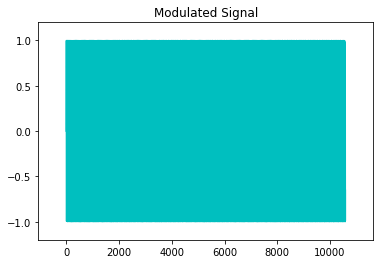

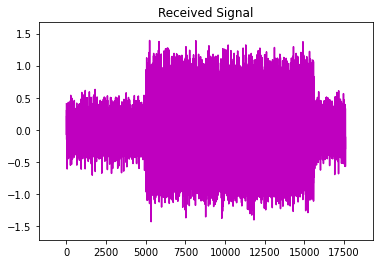

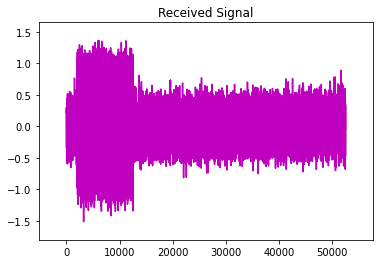

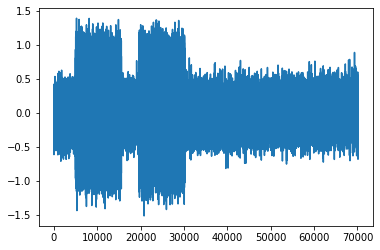

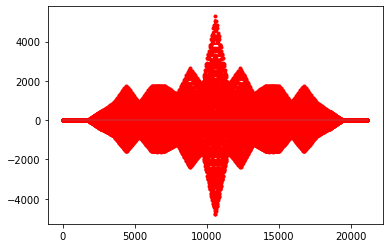

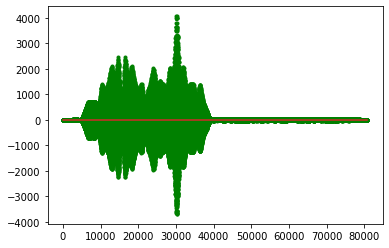

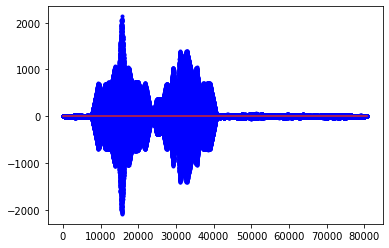

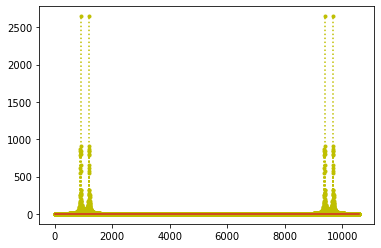

'\ncnt = 0\nfor j in range(0, mf_fft.shape[0]):\n  if(mf_fft[j] < 0.1):\n        cnt = cnt+1\n\nprint(cnt)\narr = np.zeros((cnt,))\nind = 0\nfor j in range(0, mf_fft.shape[0]):\n  if(mf_fft[j] > 0.1):\n        arr[ind] = j\n        ind = ind+1 \n\nplt.plot(mf_fft[2000:9000])\nplt.show()\n'

In [10]:
fs = 44100
Ts = 1/fs

Tb = 20e-3
samps = int(Tb*fs) 
print(samps)

n = 10
delta_f = n/(2*Tb)
print(delta_f)

f1 = delta_f*20
f0 = delta_f*15
print(f0, f1)

bits2 = np.array([0,0,1,0,1,0,1,0,0,1,1,1])

tx2 = fsk(bitseq = bits2, spb = samps, f_0 = f0, f_1 = f1, F = fs)

rx2 =  pollute(bitseq = bits2, len_f = 5000, len_b = 2000, spb = samps, f_0 = delta_f*20, f_1 = delta_f*15, F = fs, gain = 0.8, timeshift= 0, noise_stddev=0.2)
rx2 =  np.append(rx2, pollute(bitseq = bits2, len_f = 2000, len_b = 40000, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 0.8, timeshift= 0.5*Ts, noise_stddev=0.2) )
plt.plot(rx2)
plt.show()

rtt = np.correlate(tx2, tx2, mode = "full")
plt.stem(rtt, linefmt="r:", markerfmt = 'r.', use_line_collection= True)
plt.show()

rtr = np.correlate(rx2, tx2, mode = "full")
plt.stem(rtr, linefmt="g:", markerfmt = 'g.', use_line_collection= True)
plt.show() 

conv = np.convolve(rx2, mf_coef, mode = "full")
plt.stem(conv, linefmt="b:", markerfmt = 'b.', use_line_collection= True)
plt.show()


mf_coef= np.flip(tx2)
mf_fft = np.abs(np.fft.fft(mf_coef))
plt.stem(mf_fft, linefmt="y:", markerfmt = 'y.', use_line_collection= True)
plt.show()

"""
cnt = 0
for j in range(0, mf_fft.shape[0]):
  if(mf_fft[j] < 0.1):
        cnt = cnt+1

print(cnt)
arr = np.zeros((cnt,))
ind = 0
for j in range(0, mf_fft.shape[0]):
  if(mf_fft[j] > 0.1):
        arr[ind] = j
        ind = ind+1 

plt.plot(mf_fft[2000:9000])
plt.show()
"""

10584
22144
32768


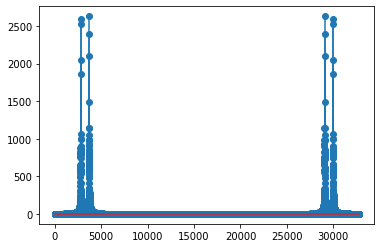

70168
*******
0
22144
32768


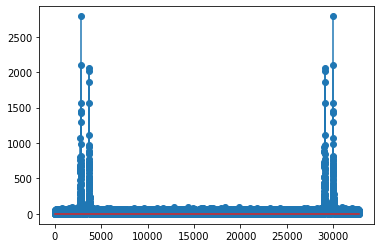

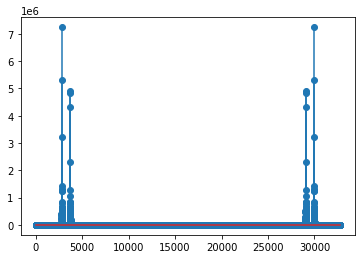

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


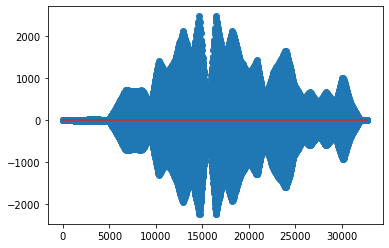

*******
22144
22144
32768


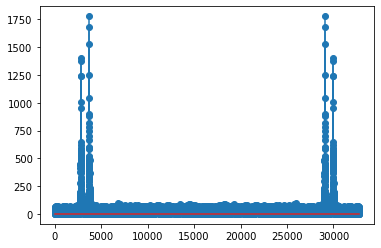

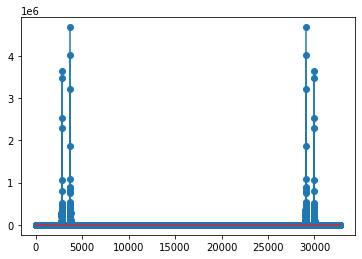

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


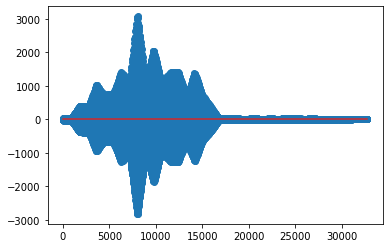

*******
44288
22144
32768


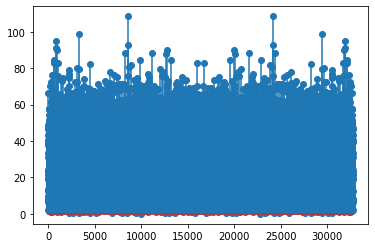

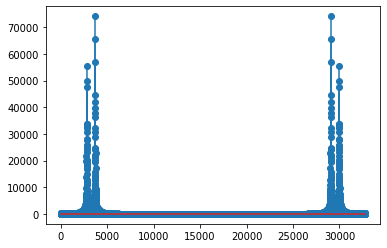

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


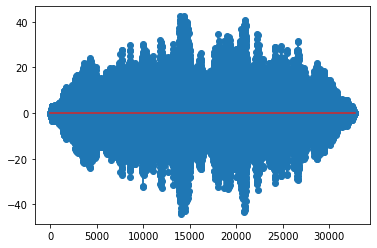

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


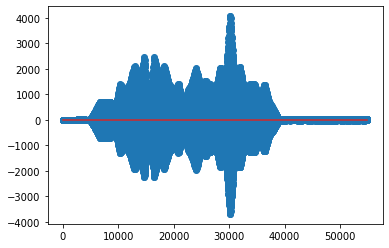

In [11]:
M = mf_coef.shape[0]
L = 128*173
N = 2**(math.ceil(math.log2(M+L-1)))
print(M)
print(L)
print(N)

yn = np.zeros(shape=(3*N,), dtype=np.complex64)

mf_coef_n = np.append(mf_coef, np.zeros(shape = (N-M,)) )

mf_fft_n = np.fft.fft(mf_coef_n)
plt.stem(np.abs(mf_fft_n), use_line_collection=True)
plt.show()

print(rx2.shape[0])
xin = np.zeros(shape = (3,N), dtype= np.complex64)

for i in range(0, 3):
  print("*******")
  index = i*L
  print(index)

  xn = rx2[index:index+L]
  print(xn.shape[0])
  xn = np.append(xn, np.zeros(shape = (N-L,)) )
  print(xn.shape[0])

  xf = np.fft.fft(xn)
  plt.stem(np.abs(xf), use_line_collection=True)
  plt.show()

  xf = xf*mf_fft_n
  plt.stem(np.abs(xf), use_line_collection=True)
  plt.show()

  xin[i] = np.fft.ifft(xf)
  plt.stem(xin[i], use_line_collection=True)
  plt.show()

yn[0:L] = xin[0][0:L]
yn[L:N] = xin[0][L:N] + xin[1][0:N-L]
yn[N:2*L] = xin[1][N-L:L]
yn[2*L:N+L] = xin[1][L:N] + xin[2][0:N-L]
yn[N+L:N+2*L] = xin[2][N-L:N]


plt.stem(yn[0:N+L], use_line_collection=True)
plt.show()

# Proof of Concept: Block Convolver/ Partitioned Overlap-Add


**Setting up:**
0.   Choose M = 32, L = 32, N = 64 

1.   Create a single-tone message of M = 96 samples

2.   Received signal = message + 96 samples padding on each side

3.   Observe cross-correlation function

4.   Matched Filter (MF) coefficients = message reversed/flipped *( h[n] = 'mf_coef' )*

5.   Split MF into **B**= 3 blocks of 32 samples and zero-pad each block to 64 samples

6.   Store N-sample FFT of each MF block *( H[k] = 'mf_fft_n' )*


**Incoming Data:**
7.   For ease of use, precalculate N-sample FFT of all input blocks *( X[k] = 'xf' )* - similar to the MF

8.   Wait until **B** input blocks are available before filtering begins 

9.   Store N-sample y[n] = IFFT{ sum of X[k].H[k] }   *( y[n] = 'yn' )*

**Overlap-Add:**
10.  Progressively overlap and add all y[n]

11.  Sanity check = difference of Cross-Correlation and Overlap-Add output


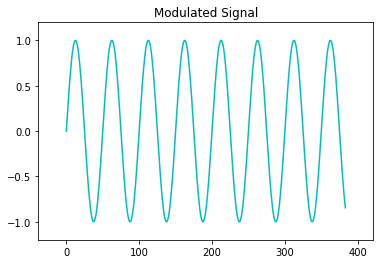

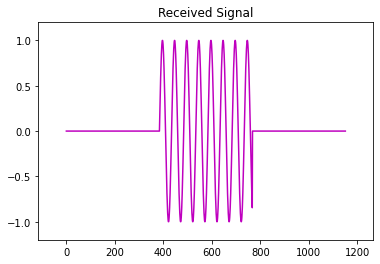

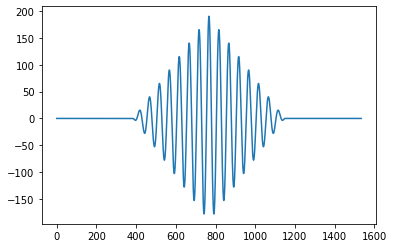

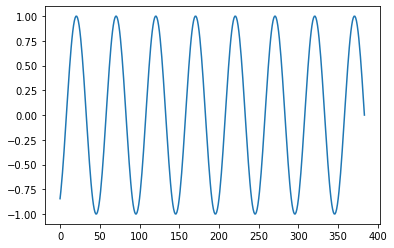

In [13]:
bt = np.array([1])
bt2 = np.array([1])
samps1 = 384
tx = fsk(bitseq = bt, spb = samps1, f_0 = f0, f_1 = 882, F = fs)
rx = pollute(bitseq = bt2, len_f = samps1, len_b= samps1, spb = samps1, f_0 = f0, f_1 = 882, F = fs, gain = 1.0, timeshift= 0.0, noise_stddev=0.0)

rtr = np.correlate(rx, tx, mode = "full")
plt.plot(rtr)
plt.show() 

mf_coef= np.flip(tx)
plt.plot(mf_coef)
plt.show()

#############################
0


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


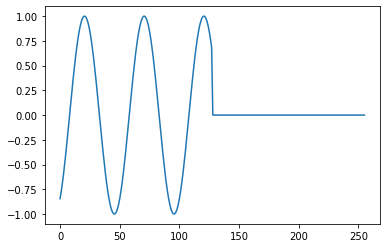

#############################
1


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


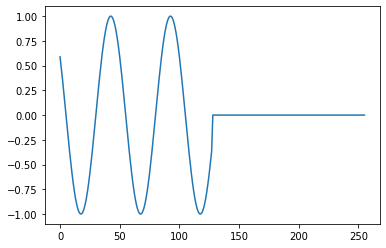

#############################
2


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


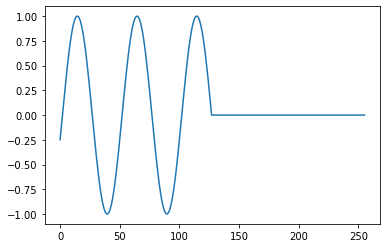

In [14]:
M = 128
L = 128
N = 256

mf_coef_n = np.zeros(shape = (3,N), dtype= np.complex64) 
mf_fft_n = np.zeros(shape = (3,N), dtype= np.complex64)


cnt = 0
for j in range(0,3):
  print("#############################")
  print(j)
  cnt = j*M
  mf_coef_n[j] = np.append(mf_coef[cnt:cnt+M] , np.zeros(shape = (N-M,)) )
  plt.plot(mf_coef_n[j])
  plt.show()

  mf_fft_n[j] = np.fft.fft( mf_coef_n[j] )
  #plt.plot((mf_fft_n[j]))
  #plt.show()

0
128
256
384
512
640
768
896
1024


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


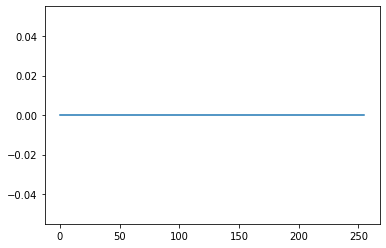

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


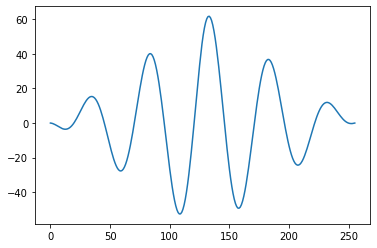

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


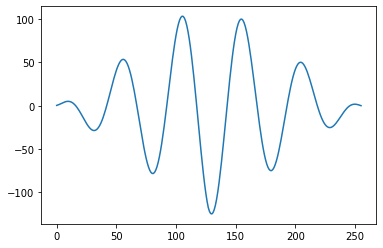

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


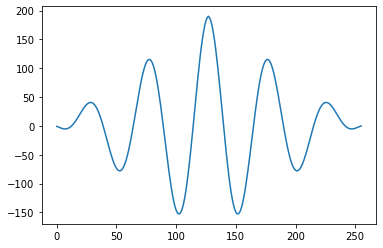

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


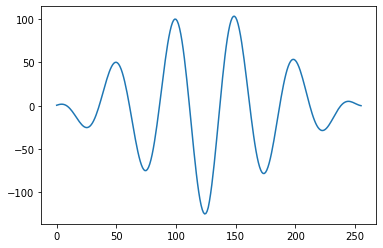

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


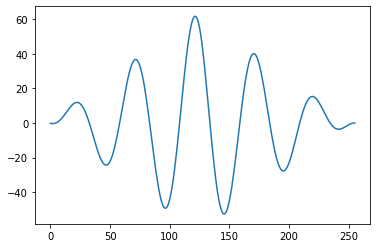

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


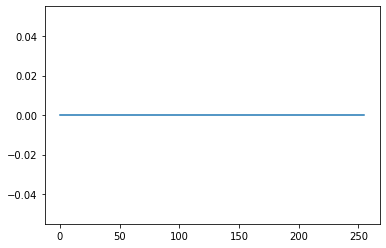

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


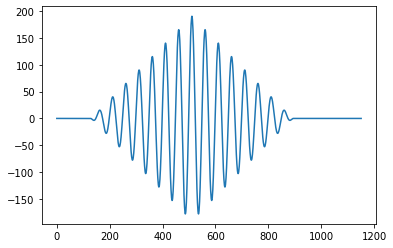

In [15]:
xf = np.zeros(shape = (9,N), dtype= np.complex64)
yn = np.zeros(shape = (7,N), dtype= np.complex64)
ola = np.zeros(shape = (N+7*L,), )

for k in range(0,9):
  cnt = k*L
  print(cnt)
  xf[k] = np.append( rx[cnt:cnt+L], np.zeros(shape = (N-L,), dtype= np.complex64) )
  xf[k] = np.fft.fft(xf[k])


for i in range(2,9):
  for j in range(0,3):
    yn[i-2] = yn[i-2] + xf[i-j]*mf_fft_n[j]

  yn[i-2] = np.fft.ifft(yn[i-2])
  plt.plot(yn[i-2])
  plt.show()


ola[0:L] = yn[0][0:L]
ola[L:N] = yn[0][L:N]

for k in range(1, 6):
  ola[k*L : N+(k-1)*L] = ola[k*L : N+(k-1)*L] + yn[k][0:N-L]
  ola[N+(k-1)*L : (k+1)*L] = yn[k][N-L:L]
  ola[(k+1)*L : N+k*L] = yn[k][L:N]

plt.plot(ola)
plt.show()

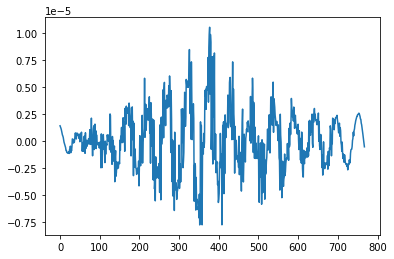

In [17]:
plt.plot(ola[128:896]-rtr[384:1152])
plt.show()

#Block Convolver designed for N= 4096

Same method as above. Hopefully can be applied to the project. 

I found it necessary to zero-pad the message such that it is a multiple of N.

882
250.0
3750.0 5000.0


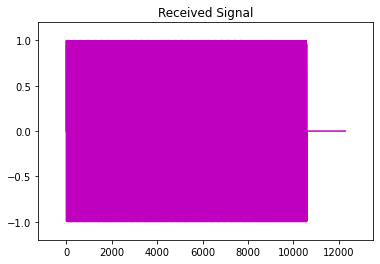

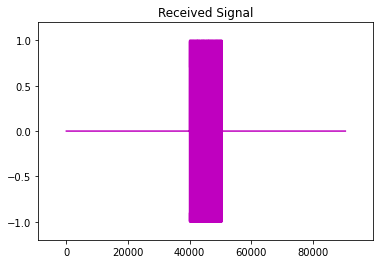

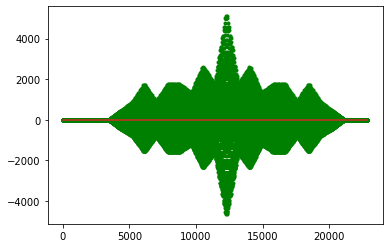

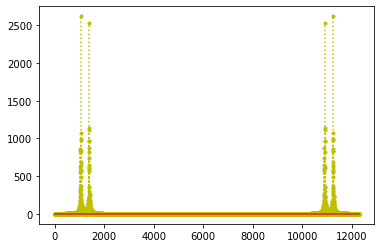

In [18]:
fs = 44100
Ts = 1/fs

Tb = 20e-3
samps = int(Tb*fs) 
print(samps)

n = 10
delta_f = n/(2*Tb)
print(delta_f)

f1 = delta_f*20
f0 = delta_f*15
print(f0, f1)


bits3 = np.array([0,0,1,0,1,0,1,0,0,1,1,1])
tx3 = pollute(bitseq = bits3, len_f = 0, len_b = 852*2, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1.0, timeshift= 0.0, noise_stddev=0.0) #FSK encoded messsage w/ zeropadding
rx3 = pollute(bitseq = bits3, len_f = 40000, len_b = 40000, spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1.0, timeshift= 0.5*Ts, noise_stddev=0.0)

rtr = np.correlate(rx3, tx3, mode = "full")
plt.stem(rtr[40000:-40000], linefmt="g:", markerfmt = 'g.', use_line_collection= True)
plt.show() 


mf_coef= np.flip(tx3)
mf_fft = np.abs(np.fft.fft(mf_coef))
plt.stem(mf_fft, linefmt="y:", markerfmt = 'y.', use_line_collection= True)
plt.show()

2048
2048
4096
#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


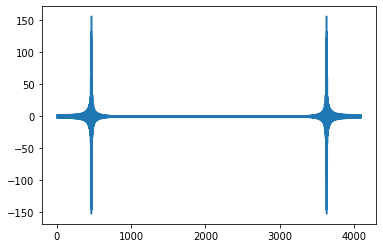

#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


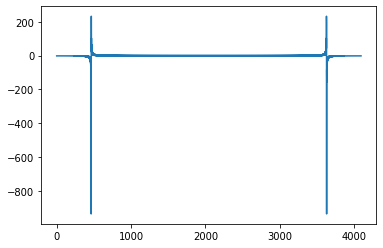

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


#############################


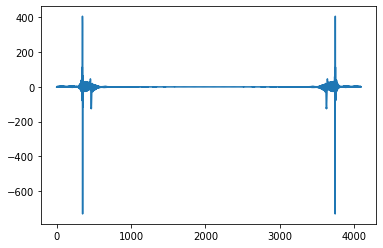

#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


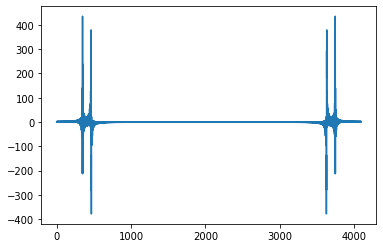

#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


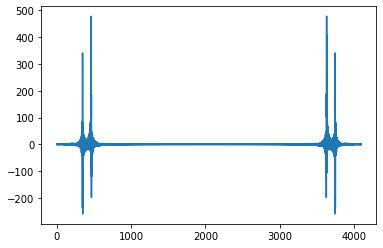

#############################


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


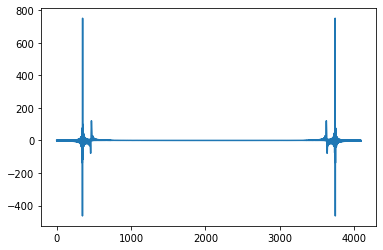

In [19]:
M = int(mf_coef.shape[0]/6)
L = 128*16
N = 2**(math.ceil(math.log2(M+L-1)))
print(M)
print(L)
print(N)

mf_coef_n = np.zeros(shape = (6,N), dtype= np.complex64) 
mf_fft_n = np.zeros(shape = (6,N), dtype= np.complex64)


cnt = 0
for j in range(0,6):
  print("#############################")
  cnt = j*M
  mf_coef_n[j] = np.append(mf_coef[cnt:cnt+M] , np.zeros(shape = (N-M,)) )
  #plt.plot(mf_coef_n[j])
  #plt.show()

  mf_fft_n[j] = np.fft.fft( mf_coef_n[j] )
  plt.plot((mf_fft_n[j]))
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


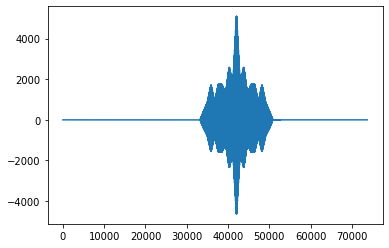

In [20]:
xf = np.zeros(shape = (39,N), dtype= np.complex64)
yn = np.zeros(shape = (34,N), dtype= np.complex64)
ola = np.zeros(shape = (N+34*L,), )

for k in range(0, 39):
  cnt = k*L
  xf[k] = np.append( rx3[cnt:cnt+L], np.zeros(shape = (N-L,), dtype= np.complex64) )
  xf[k] = np.fft.fft(xf[k])
  #plt.plot(xf[k])
  #plt.show()

for i in range(5,39):
  for j in range(0,6):
    yn[i-5] = yn[i-5] + xf[i-j]*mf_fft_n[j]
  yn[i-5] = np.fft.ifft(yn[i-5])
  #plt.plot(yn[i-5])
  #plt.show()


ola[0:L] = yn[0][0:L]
ola[L:N] = yn[0][L:N]

for k in range(1, 34):
  ola[k*L : N+(k-1)*L] = ola[k*L : N+(k-1)*L] + yn[k][0:N-L]
  ola[N+(k-1)*L : (k+1)*L] = yn[k][N-L:L]
  ola[(k+1)*L : N+k*L] = yn[k][L:N]

plt.plot(ola)
plt.show()

#Junk Code

In [21]:
M = int(mf_coef.shape[0]/6)
L = 128*18
N = 2**(math.ceil(math.log2(M+L-1)))
print(M)
print(L)
print(N)

mf_coef_n = np.zeros(shape = (6,N), dtype= np.complex64) 
mf_fft_n = np.zeros(shape = (6,N), dtype= np.complex64) 

cnt = 0
for j in range(0, 6):
  cnt = j*M
  mf_coef_n[j] = np.append( mf_coef[cnt:cnt+M], np.zeros(shape = (N-M,)) )
  mf_fft_n[j] = np.fft.fft( mf_coef_n[j] )

  #plt.stem(np.abs(mf_fft_n[j]), use_line_collection=True)
  #plt.show()


yn = np.zeros(shape=(3*N,), dtype=np.complex64)

print(rx2.shape[0])
xin = np.zeros(shape = (6,N), dtype= np.complex64) 
headx = 0

for i in range(0, 16):
  print("*******")
  index = i*L
  print(index)

  xn = rx2[index:index+L]
  xn = np.append(xn, np.zeros(shape = (N-L,)) )
  xin[headx] = xn

  for i in range(0, 6):
    cnt = headx + i
    if (cnt > 5):
      cnt = cnt-6
    xin[cnt] = np.fft.fft(xin[cnt])*np.fft.fft(mf_coef_n[i])
    #plt.plot( np.abs(xin[i]) )
    #plt.show()

  #plt.plot( np.abs( np.fft.ifft( np.sum(xin, axis = 0) ) ) )
  #plt.show()

  if (headx >= 5):
    headx = 0
  else:
    headx = headx + 1

"""
yn[0:L] = xin[0][0:L]
yn[L:N] = xin[0][L:N] + xin[1][0:N-L]
yn[N:2*L] = xin[1][N-L:L]
yn[2*L:N+L] = xin[1][L:N] + xin[2][0:N-L]
yn[N+L:N+2*L] = xin[2][N-L:N]
"""

#plt.stem(yn[0:N+L], use_line_collection=True)
#plt.show()

2048
2304
8192
70168
*******
0
*******
2304
*******
4608
*******
6912
*******
9216
*******
11520
*******
13824
*******
16128
*******
18432
*******
20736
*******
23040
*******
25344
*******
27648
*******
29952
*******
32256
*******
34560


'\nyn[0:L] = xin[0][0:L]\nyn[L:N] = xin[0][L:N] + xin[1][0:N-L]\nyn[N:2*L] = xin[1][N-L:L]\nyn[2*L:N+L] = xin[1][L:N] + xin[2][0:N-L]\nyn[N+L:N+2*L] = xin[2][N-L:N]\n'

In [ ]:
M = int(mf_coef.shape[0]/6)
L = 128*16
N = 2**(math.ceil(math.log2(M+L-1)))
print(M)
print(L)
print(N)

mf_coef_n = np.zeros(shape = (6,N), dtype= np.complex64) 
mf_fft_n = np.zeros(shape = (6,N), dtype= np.complex64)

cnt = 0
for j in range(0,6):
  cnt = j*M
  mf_coef_n[j] = np.append(mf_coef[cnt:cnt+M] , np.zeros(shape = (N-M,)) )
  #plt.plot(mf_coef_n[j])
  #plt.show()
  mf_fft_n[j] = np.fft.fft( mf_coef_n[j] )

  #plt.plot(np.abs(mf_fft_n[j]))
  #plt.show()


xf = np.zeros(shape = (6,N), dtype= np.complex64)

yn = np.zeros(shape = (6,N), dtype= np.complex64)

"""
xf[5] = np.append( rx1[0*L:1*L], np.zeros(shape = (N-L,)) )
xf[4] = np.append( rx1[1*L:2*L], np.zeros(shape = (N-L,)) )
xf[3] = np.append( rx1[2*L:3*L], np.zeros(shape = (N-L,)) )
xf[2] = np.append( rx1[3*L:4*L], np.zeros(shape = (N-L,)) )
xf[1] = np.append( rx1[4*L:5*L], np.zeros(shape = (N-L,)) )
xf[0] = np.append( rx1[5*L:6*L], np.zeros(shape = (N-L,)) )

xf[0] = np.fft.fft(xf[0])
xf[1] = np.fft.fft(xf[1])
xf[2] = np.fft.fft(xf[2])
xf[3] = np.fft.fft(xf[3])
xf[4] = np.fft.fft(xf[4])
xf[5] = np.fft.fft(xf[5])
"""

out = np.zeros(shape = (15,N), dtype= np.complex64)
ola = np.zeros(shape = (N+20*L,), dtype= np.complex64)

for k in range(0, 15):
  cnt = k*L
  for j in range(0, 6):
    cnt = cnt+L
    xf[j] = np.append( rx1[cnt:cnt+L], np.zeros(shape = (N-L,)) )
    xf[j] = np.fft.fft(xf[j])
    yn[j] = xf[j]*mf_fft_n[5-j]
    #plt.plot(yn[j])
    #plt.show()

  out[k] = np.fft.ifft(yn[0])+np.fft.ifft(yn[1])+np.fft.ifft(yn[2])+np.fft.ifft(yn[3])+np.fft.ifft(yn[4])+np.fft.ifft(yn[5])
  #plt.plot(out[k])
  #plt.show()

ola[0:L] = out[0][0:L]
ola[L:N] = out[0][L:N]

for k in range(1, 15):
  ola[k*L : N+(k-1)*L] = ola[k*L : N+(k-1)*L] + out[k][0:N-L]
  ola[N+(k-1)*L : (k+1)*L] = out[k][N-L:L]
  ola[(k+1)*L : N+k*L] = out[k][L:N]

plt.plot(ola[0:10000])
plt.show()

"""
out = np.zeros(shape = (N+L*6), dtype= np.complex64)
out[0 : 1*L] = yn[0][0:L]
out[1*L : N+0*L] = yn[0][L:N] + yn[1][0:N-L]
out[N+0*L : 2*L] = yn[1][N-L:L]
out[2*L : N+1*L] = yn[1][L:N] + yn[2][0:N-L]
out[N+1*L : 3*L] = yn[2][N-L:L]
out[3*L : N+2*L] = yn[2][L:N] + yn[3][0:N-L]
out[N+2*L : 4*L] = yn[3][N-L:L]
out[4*L : N+3*L] = yn[3][L:N] + yn[4][0:N-L]
out[N+3*L : 5*L] = yn[4][N-L:L]

plt.plot(out)
plt.show()
"""

In [ ]:
M = int(mf_coef.shape[0]/6)
L = 128*18
N = 2**(math.ceil(math.log2(M+L-1)))
print(M)
print(L)
print(N)

mf_coef_n = np.zeros(shape = (6,N), dtype= np.complex64) 
mf_fft_n = np.zeros(shape = (6,N), dtype= np.complex64) 

cnt = 0
for j in range(0, 6):
  cnt = j*M
  mf_coef_n[j] = np.append( mf_coef[cnt:cnt+M], np.zeros(shape = (N-M,)) )
  mf_fft_n[j] = np.fft.fft( mf_coef_n[j] )
  #plt.stem(np.abs(mf_fft_n[j]), use_line_collection=True)
  #plt.show()


yn = np.zeros(shape=(3*N,), dtype=np.complex64)

print(rx1.shape[0])
xin = np.zeros(shape = (6,N), dtype= np.complex64) 
headx = 0

for i in range(0, 16):
  print("*******")
  index = i*L
  print(index)

  xn = rx1[index:index+L]
  xn = np.append(xn, np.zeros(shape = (N-L,)) )
  xin[headx] = xn

  for i in range(0, 6):
    cnt = headx + i
    if (cnt > 5):
      cnt = cnt-6
    xin[cnt] = np.fft.fft(xin[cnt])*np.fft.fft(mf_coef_n[i])
    #plt.plot( np.abs(xin[i]) )
    #plt.show()

  plt.plot( np.abs( np.fft.ifft( np.sum(xin, axis = 0) ) ) )
  plt.show()

  if (headx >= 5):
    headx = 0
  else:
    headx = headx + 1

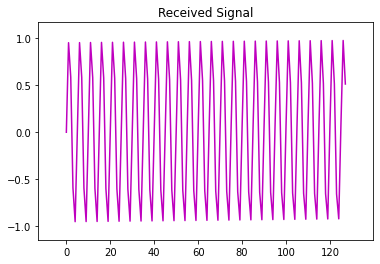

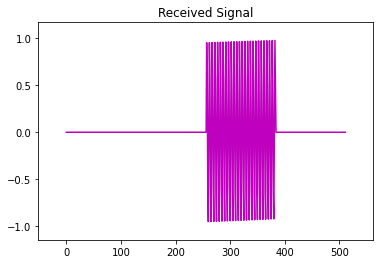

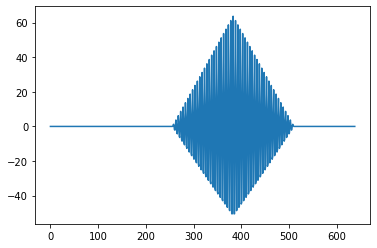

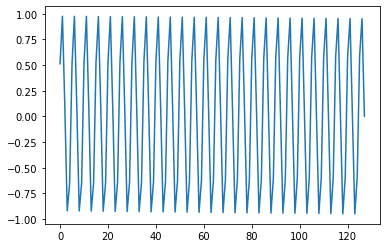

In [22]:
bits4 = np.array([1])
fs = 44100
Ts = 1/fs
samps = 128
f0 = 5000
f1 = 8825

tx4 = pollute(bitseq = bits4, len_f = 0, len_b= 0,spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1.0, timeshift= 0.0, noise_stddev=0.0)

rx4 = pollute(bitseq = bits4, len_f = 256, len_b= 128,spb = samps, f_0 = f0, f_1 = f1, F = fs, gain = 1.0, timeshift= 0.0, noise_stddev=0.0)

rtr = np.correlate(rx4, tx4, mode = "full")
plt.plot(rtr)
plt.show() 

mf_coef= np.flip(tx4)
plt.plot(mf_coef)
plt.show()

mf_coef = np.append(mf_coef, np.zeros(shape = (128,) ) )

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


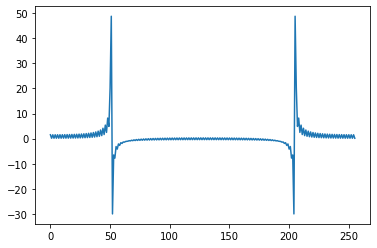

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


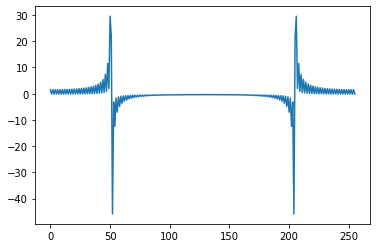

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


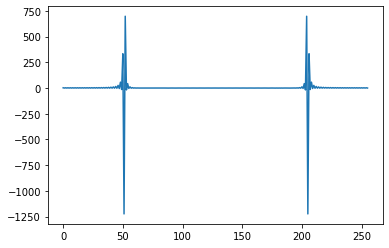

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


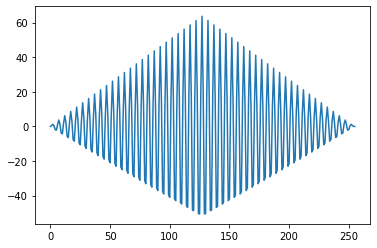

In [ ]:
mf_fft = np.fft.fft(mf_coef)
rx_fft = np.fft.fft(rx4[256:512])

#print(rx_fft[45:55])

plt.plot(mf_fft)
plt.show()

plt.plot(rx_fft)
plt.show()

y = rx_fft*mf_fft
plt.plot(y)
plt.show()


plt.plot(np.fft.ifft(y))
plt.show()

(128,)


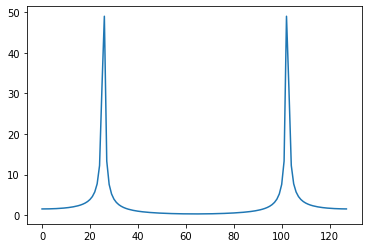

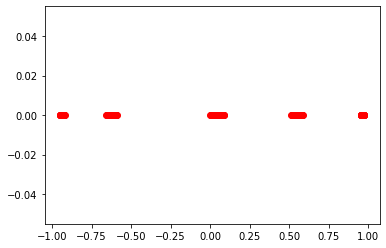

In [ ]:
print(tx4.shape)
plt.plot(np.abs(np.fft.fft(tx4)))
plt.show()

X = [x.real for x in tx4]
Y = [x.imag for x in tx4]
plt.scatter(X,Y, color='red')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


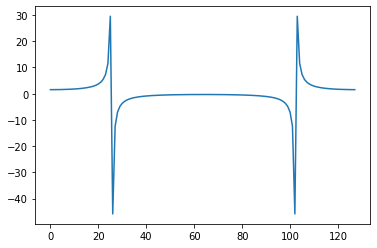

ValueError: ignored

In [ ]:
y = np.zeros(shape = (128,))

for k in range(0, 2):
  ind = 128*k
  work = tx4[ind:ind+128]
  #work = 2*np.append(tx4[ind:ind+128], np.zeros(shape = (128,)))
  plt.plot(np.fft.fft(work))
  plt.show() 
  y = y + np.fft.fft(work)

plt.plot(np.abs(y))
plt.show()  
